## 1. Decision Trees as Interpretable Models

Import packages

In [433]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [434]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, _tree
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

### (a) Obtain Data

Get the Accute Inamations Data Set

In [437]:
column_names = ['Temperature', 'Nausea', 'Lumbar_pain', 'Urine', 
                'Micturition_pains', 'Urethra', 'Inflammation', 'Nephritis']
df = pd.read_csv("../data/diagnosis.data", header=None,encoding='utf-16', delimiter='\t', names=column_names)
print(df.head())

  Temperature Nausea Lumbar_pain Urine Micturition_pains Urethra Inflammation  \
0        35,5     no         yes    no                no      no           no   
1        35,9     no          no   yes               yes     yes          yes   
2        35,9     no         yes    no                no      no           no   
3        36,0     no          no   yes               yes     yes          yes   
4        36,0     no         yes    no                no      no           no   

  Nephritis  
0        no  
1        no  
2        no  
3        no  
4        no  


In [438]:
df['Temperature'] = df['Temperature'].str.replace(',', '.')
df['Temperature'] = df['Temperature'].astype(float)
df.head()

,Temperature,Nausea,Lumbar_pain,Urine,Micturition_pains,Urethra,Inflammation,Nephritis
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no


In [439]:
df = df.replace({'yes': 1, 'no': 0})
df.head()

,Temperature,Nausea,Lumbar_pain,Urine,Micturition_pains,Urethra,Inflammation,Nephritis
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0


### (b) Build a decision tree

In [441]:
clf = []
for i in range(len(df)):
    if df['Inflammation'].iloc[i] == 0 and df['Nephritis'].iloc[i] == 0:
        clf.append(1)
    if df['Inflammation'].iloc[i] == 1 and df['Nephritis'].iloc[i] == 0:
        clf.append(2)
    if df['Inflammation'].iloc[i] == 0 and df['Nephritis'].iloc[i]== 1:
        clf.append(3)
    if df['Inflammation'].iloc[i] == 1 and df['Nephritis'].iloc[i] == 1:
        clf.append(4)
df["Class"] = clf
df

,Temperature,Nausea,Lumbar_pain,Urine,Micturition_pains,Urethra,Inflammation,Nephritis,Class
0,35.5,0,1,0,0,0,0,0,1
1,35.9,0,0,1,1,1,1,0,2
2,35.9,0,1,0,0,0,0,0,1
3,36.0,0,0,1,1,1,1,0,2
4,36.0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1,3
116,41.5,0,0,0,0,0,0,0,1
117,41.5,1,1,0,1,0,0,1,3
118,41.5,0,1,1,0,1,0,1,3


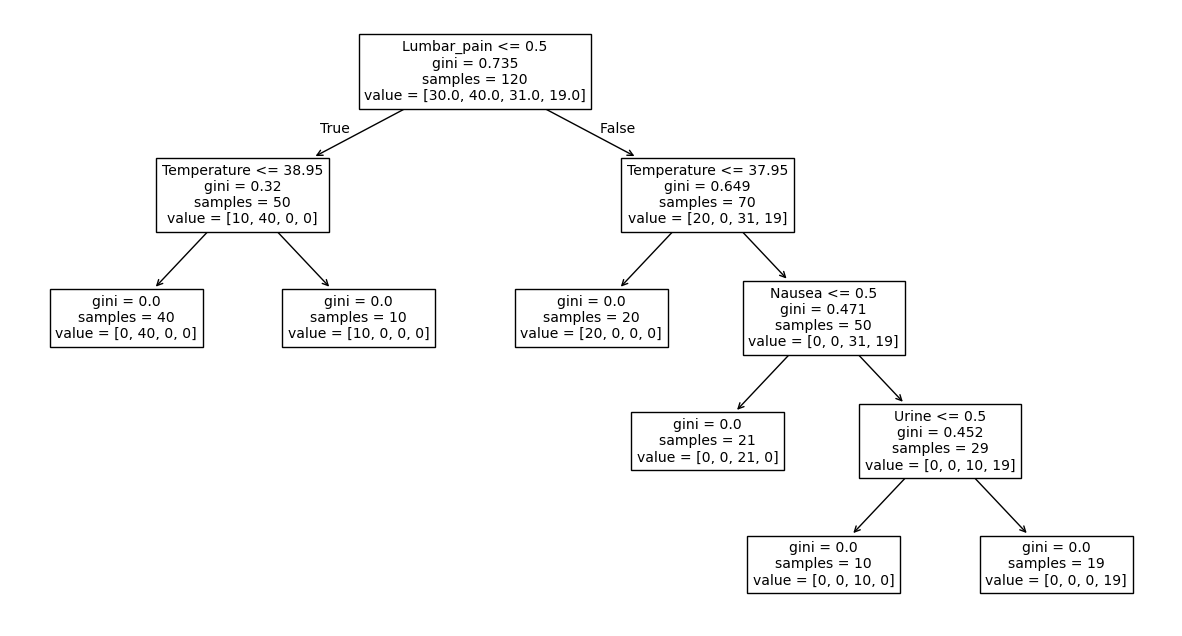

In [442]:
X = df.iloc[:, 0 :6]
Y = df.iloc[:, -1:]

# Fit decision tree model
tree_full = tree.DecisionTreeClassifier()
tree_full = tree_full.fit(X, Y)
plt.figure(figsize=(15, 8))
tree.plot_tree(tree_full, feature_names=X.columns)
plt.show()


### (c) Convert the decision rules

In [444]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

tree_to_code(tree_full, X.columns)

def tree(Temperature, Nausea, Lumbar_pain, Urine, Micturition_pains, Urethra):
  if Lumbar_pain <= 0.5:
    if Temperature <= 38.95000076293945:
      return [[0. 1. 0. 0.]]
    else:  # if Temperature > 38.95000076293945
      return [[1. 0. 0. 0.]]
  else:  # if Lumbar_pain > 0.5
    if Temperature <= 37.95000076293945:
      return [[1. 0. 0. 0.]]
    else:  # if Temperature > 37.95000076293945
      if Nausea <= 0.5:
        return [[0. 0. 1. 0.]]
      else:  # if Nausea > 0.5
        if Urine <= 0.5:
          return [[0. 0. 1. 0.]]
        else:  # if Urine > 0.5
          return [[0. 0. 0. 1.]]


### (d) Cost complexity pruning

Best alpha value: 0.0


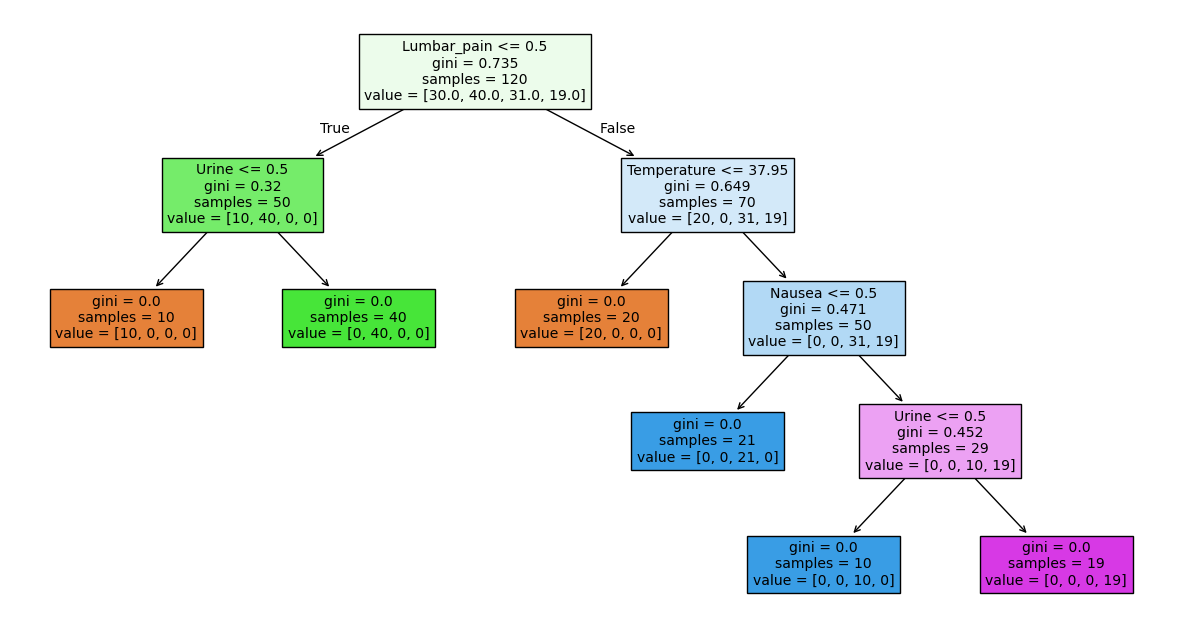

In [446]:
path = tree_full.cost_complexity_pruning_path(X, Y)
ccp_alphas = path.ccp_alphas
param_grid = {'ccp_alpha': ccp_alphas}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X, Y)
best_tree_full = grid_search.best_estimator_
print(f"Best alpha value: {grid_search.best_params_['ccp_alpha']}")

plt.figure(figsize=(15,8))
tree.plot_tree(best_tree_full, feature_names=X.columns, filled=True)
plt.show()

## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [449]:
df2 = pd.read_csv("../data/communities.data", header=None)
df2

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


### (b) Missing values

In [451]:
#dropping first 5 non-predictive columns
df2.drop([0, 1, 2, 3, 4], axis=1, inplace=True)

df2 = df2.replace('?', np.nan)
imputer = SimpleImputer(strategy='median')
imputer.fit(df2)
df2 = pd.DataFrame(imputer.transform(df2), columns = df2.columns)
df2

,5,6,7,8,9,10,11,12,13,14,...,118,119,120,121,122,123,124,125,126,127
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.08,0.03,0.75,0.5,0.00,0.15,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.08,0.03,0.75,0.5,0.00,0.15,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.08,0.03,0.75,0.5,0.00,0.15,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.08,0.03,0.75,0.5,0.00,0.15,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.08,0.03,0.75,0.5,0.00,0.15,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.08,0.03,0.75,0.5,0.00,0.15,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


In [452]:
train = df2[:1495]
test = df2[1495:]


In [453]:
X_train = df2.iloc[:, :-1]
y_train = df2.iloc[:, -1:]
X_test = df2.iloc[:, :-1]
y_test = df2.iloc[:, -1:]

### (c) Plot a correlation matrix

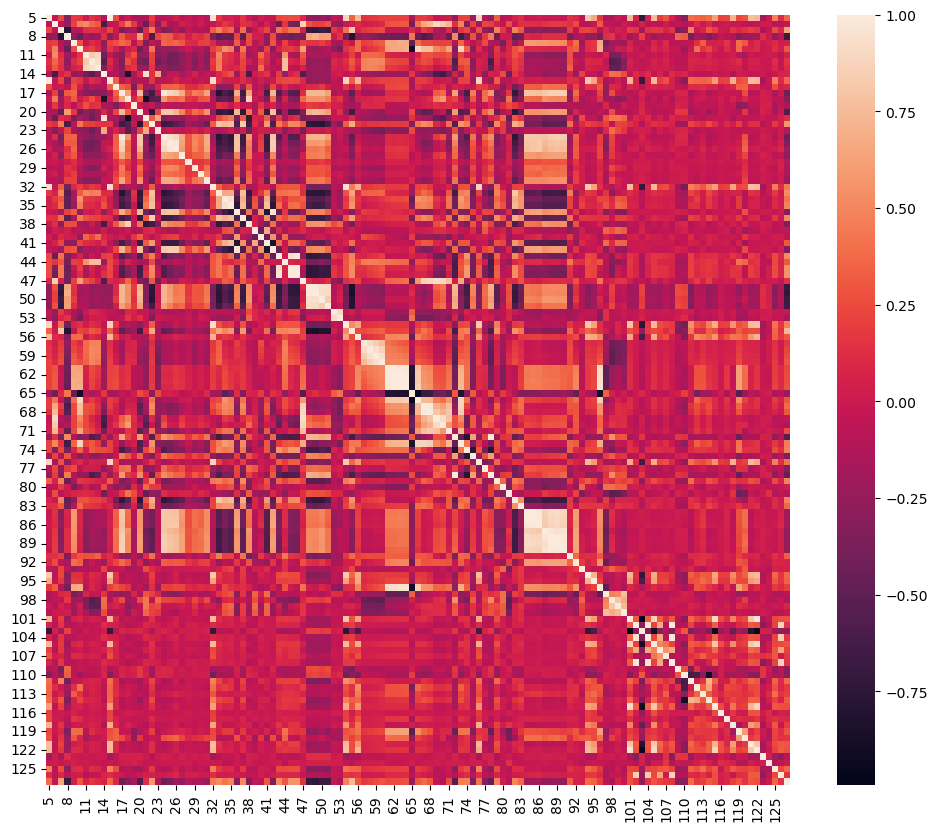

In [455]:
plt.figure(figsize=(12,10))
sns.heatmap(df2.corr())
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [457]:
df_features = pd.concat([X_train,X_test])
cv = df_features.std() / df_features.mean()
print(cv)

5      2.203226
6      0.353254
7      1.410743
8      0.323741
9      1.358992
         ...   
122    1.562704
123    0.117964
124    0.333441
125    2.554946
126    0.431470
Length: 122, dtype: float64


### (e) Scatter plots and box plots for highest CV features

In [459]:
cv_sorted = cv.sort_values(ascending=False)
n_features = int(math.sqrt(128))
top_features = cv_sorted.index[:n_features]
top_features

Index([113, 95, 94, 54, 56, 125, 32, 5, 101, 15, 76], dtype='int64')

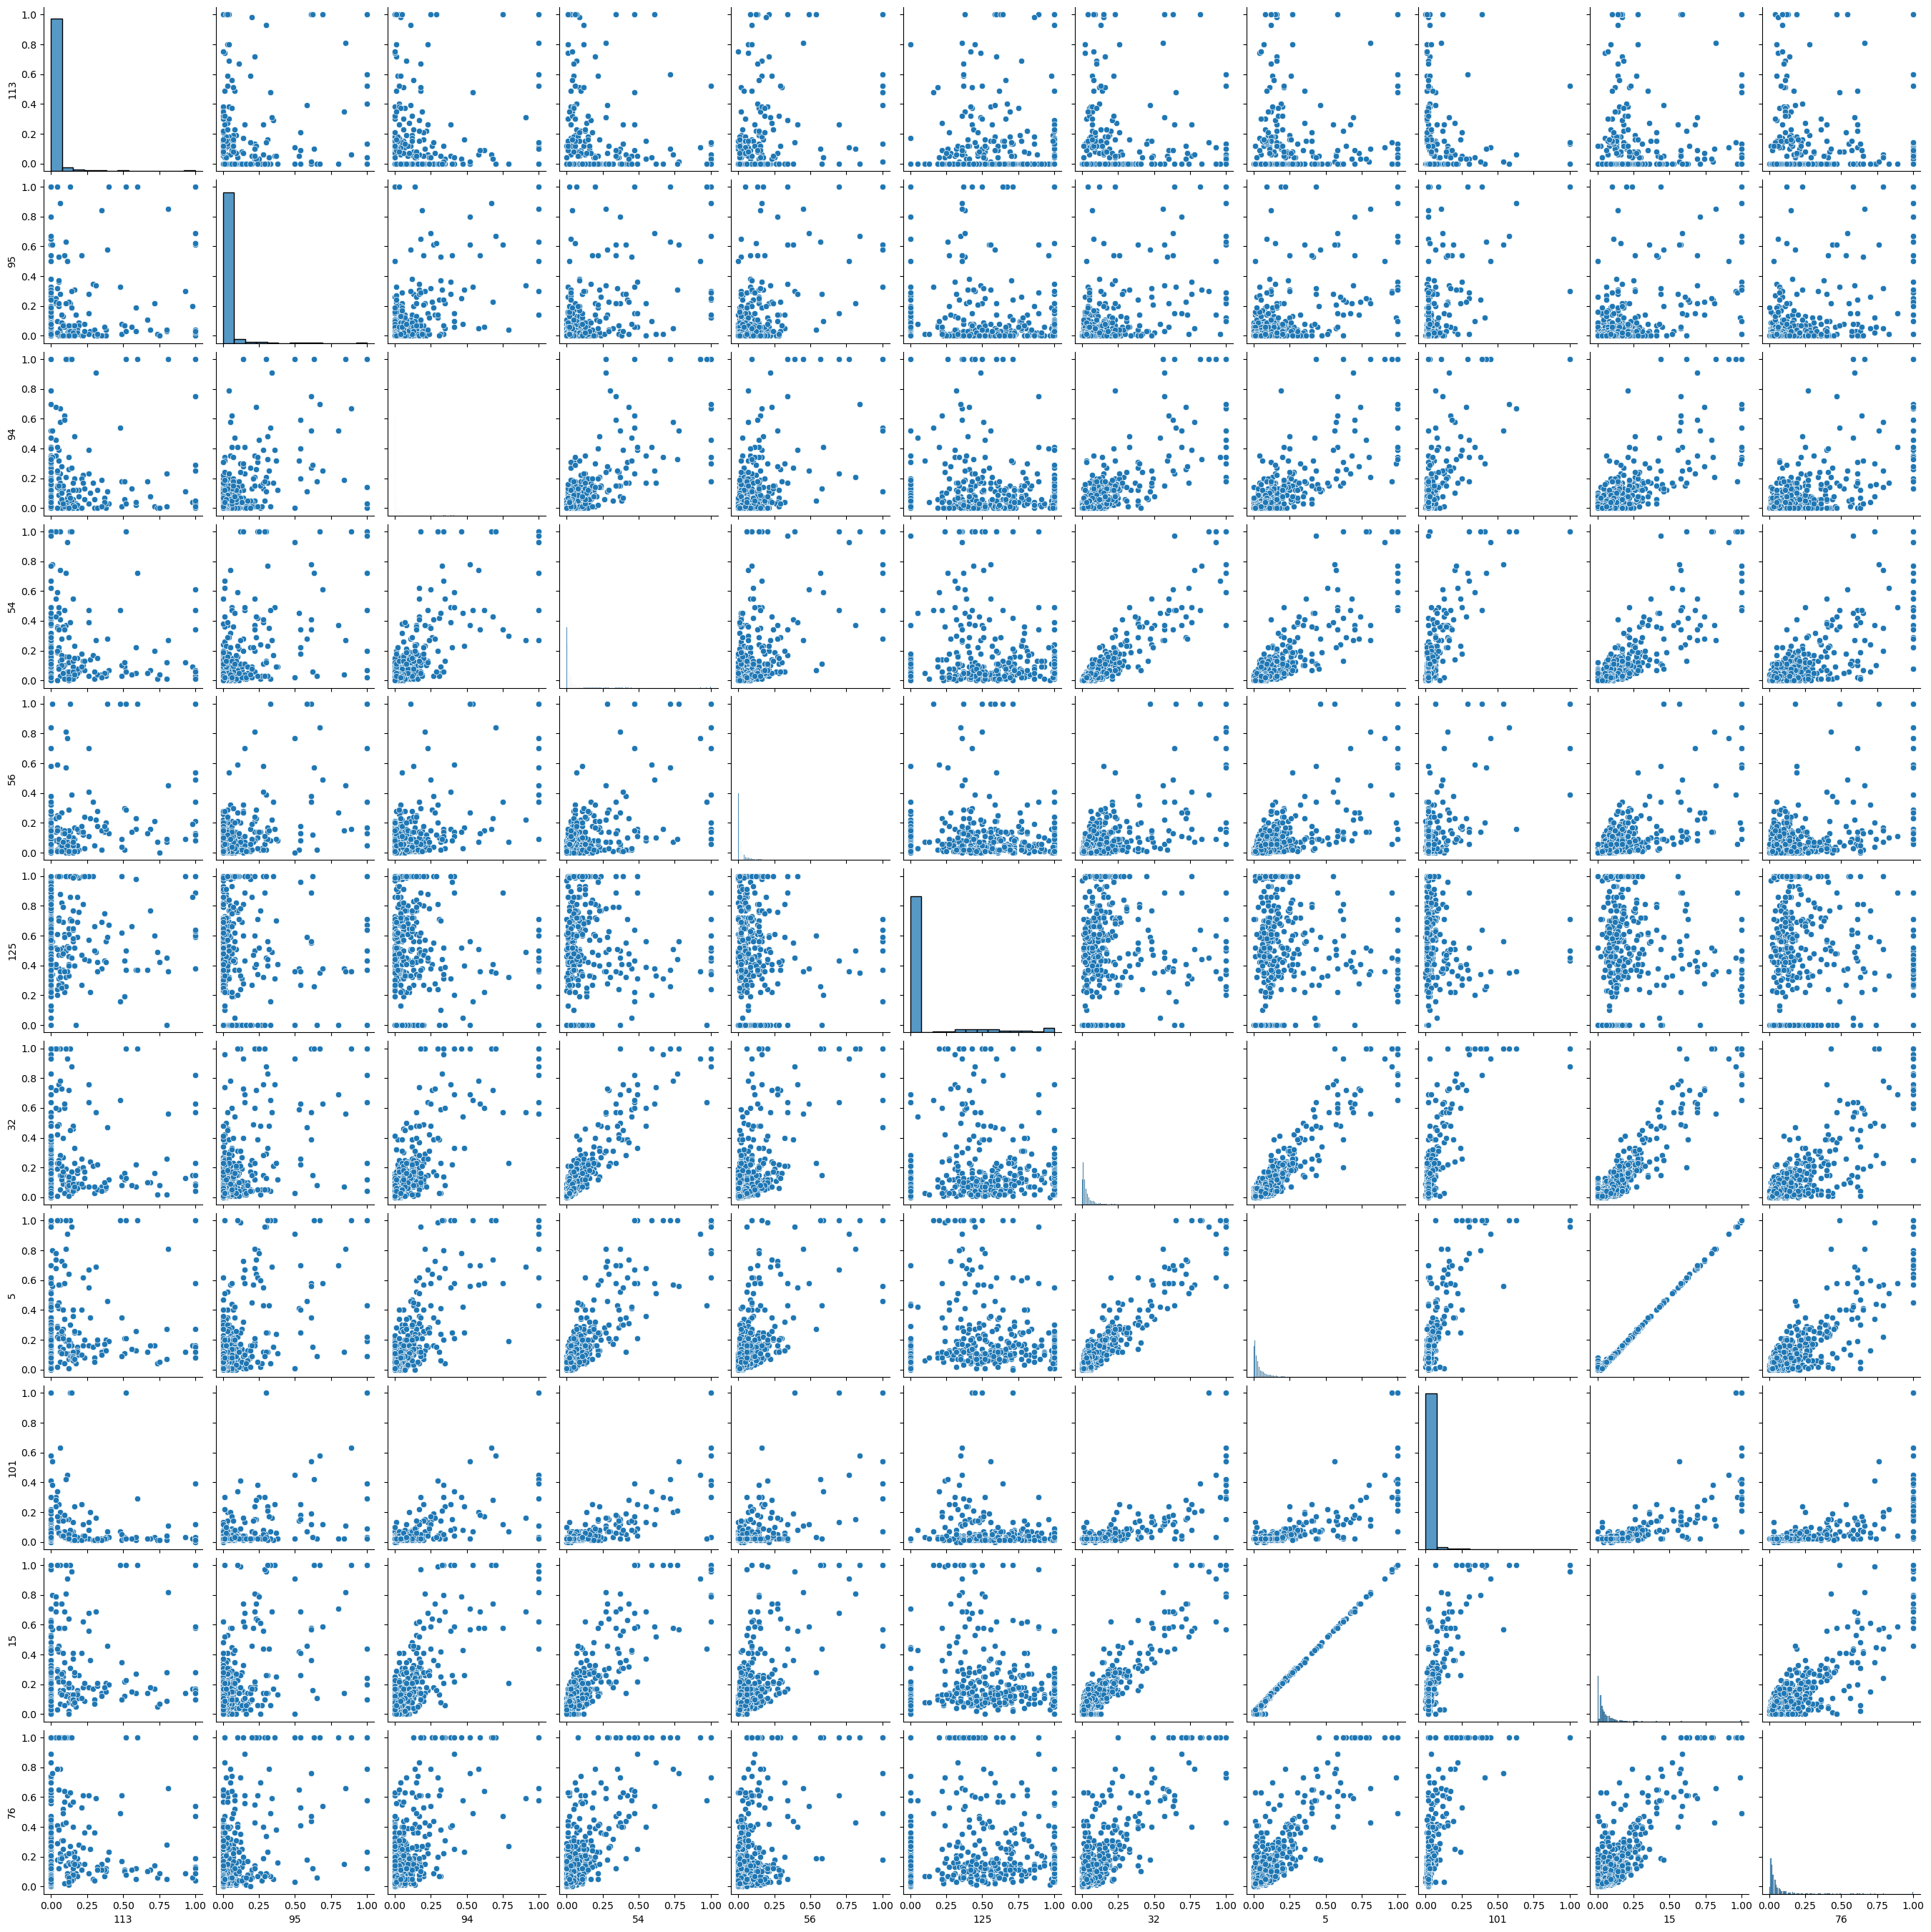

In [460]:
sns.pairplot(df_features[list(top_features)])

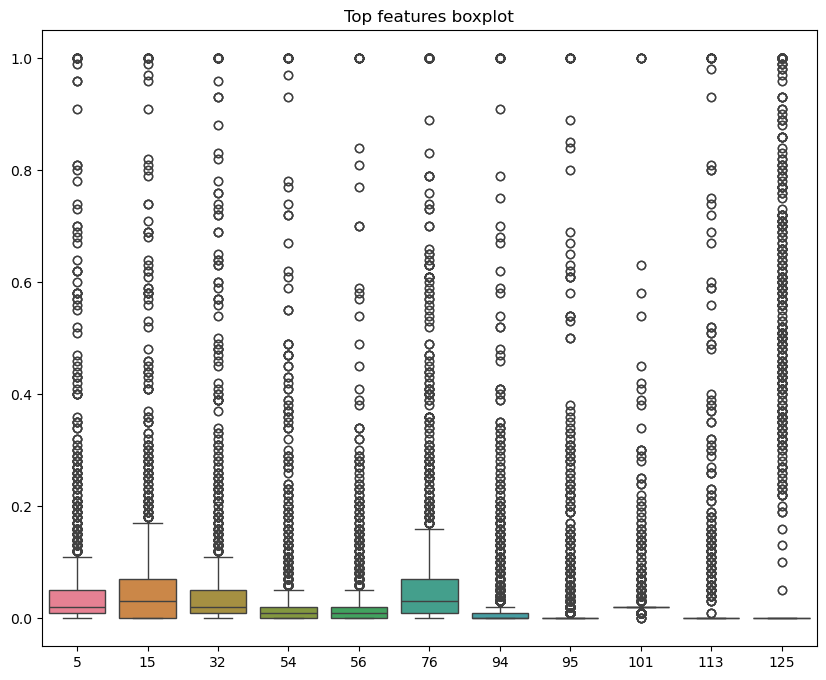

In [461]:
plt.figure(figsize=(10,8))
sns.boxplot(data=df_features[list(top_features)])
plt.title("Top features boxplot")
plt.show()

A positive correlation can be seen from Feature 5 and Feature 15, but more evidence is necessary to draw conclusions from other feartures in the scatter plot.

### (f) Fit a linear model

In [464]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)
test_error = mean_squared_error(y_test, y_pred)
print(f"Test MSE for Linear Regression: {test_error}")

Test MSE for Linear Regression: 0.016235367505943794


### (g) Fit a ridge regression model

In [466]:
lambda_list = np.logspace(-5, 5, 100)

ridge = RidgeCV(alphas=lambda_list, cv=5)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
test_error_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f"Best alpha for Ridge: {ridge.alpha_}")
print(f"Test MSE for Ridge Regression: {test_error_ridge}")

Best alpha for Ridge: 2.2570197196339215
Test MSE for Ridge Regression: 0.016781432547295038


### (h) Fit a LASSO model

In [468]:
# LASSO
model_lasso = LassoCV(alphas=lambda_list, cv=5, random_state=42)
model_lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)
test_error_lasso = mean_squared_error(y_test, y_pred_lasso)
print("Lasso:")
print(f"Best alpha for LASSO: {lasso.alpha_}")
print(f"Test MSE for LASSO: {test_error_lasso}")
selected_var = X_train.columns[lasso.coef_ != 0]
print(selected_var.tolist())
print(f"Number of features selected: {sum(lasso.coef_ != 0)}")


Lasso:
Best alpha for LASSO: 6.440031513271716e-05
Test MSE for LASSO: 0.016620754015424448
[7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 49, 50, 52, 53, 54, 55, 56, 57, 59, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 87, 90, 91, 92, 93, 94, 95, 96, 99, 100, 104, 105, 107, 109, 110, 111, 112, 113, 116, 117, 118, 120, 121, 124, 125]
Number of features selected: 87


In [469]:
# LASSO with standardization
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
y_train_std = scaler.fit_transform(y_train)

lasso_std = LassoCV(alphas=lambda_list, cv=5, random_state=42)
lasso_std.fit(X_train_std, y_train_std)

y_pred_lasso_std = lasso_std.predict(X_test)
test_error_lasso_std = mean_squared_error(y_test, y_pred_lasso_std)
print("Lasso with standardization:")
print(f"Best alpha for LASSO: {lasso_std.alpha_}")
print(f"Test MSE for LASSO: {test_error_lasso_std}")
selected_var_std = X_train.columns[lasso_std.coef_ != 0]
print(selected_var_std.tolist())
print(f"Number of features selected: {sum(lasso_std.coef_ != 0)}")

Lasso with standardization:
Best alpha for LASSO: 0.0016681005372000592
Test MSE for LASSO: 0.2599475291933334
[7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 36, 37, 38, 39, 41, 42, 43, 44, 45, 49, 50, 52, 53, 54, 55, 56, 57, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 87, 90, 91, 92, 93, 94, 95, 96, 99, 100, 104, 105, 106, 107, 109, 110, 111, 112, 113, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126]
Number of features selected: 89


We can see an increse in MSE when we standardize the features.

### (i) Fit a PCR model

In [472]:
pipeline = Pipeline([('pca', PCA()),('regression', LinearRegression())])
param_grid = {'pca__n_components': range(1, 123)}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_pcr = grid_search.best_estimator_
best_m_components = grid_search.best_params_['pca__n_components']

y_pred_pcr = best_pcr.predict(X_test)
test_error_pcr = mean_squared_error(y_test, y_pred_pcr)
print(f"Best number of components (M): {best_m_components}")
print(f"Test MSE for PCR: {test_error_pcr}")

Best number of components (M): 97
Test MSE for PCR: 0.01659829619777146


Reference: https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html

### (j) Fit a boosting tree

In [475]:
model_xgb = xgb.XGBRegressor(verbosity=0)
param_grids = {'reg_alpha': lambda_list, 'random_state':[42]}
gridSearch = GridSearchCV(model_xgb, param_grid=param_grids, cv=5, scoring='neg_mean_squared_error')
gridSearch.fit(X_train, y_train)

gridSearch_alphas = gridSearch.cv_results_['param_reg_alpha']
gridSearch_score = -gridSearch.cv_results_['mean_test_score']
gridSearch_std = gridSearch.cv_results_['std_test_score']

df_result = pd.DataFrame({'alpha': gridSearch_alphas, 'mse': gridSearch_score, 'std': gridSearch_std})
df_result = df_result.sort_values(['mse'], ascending = True)
display(df_result)

,alpha,mse,std
55,3.593814,0.019614,0.002816
54,2.848036,0.019755,0.002989
52,1.788650,0.019771,0.003055
49,0.890215,0.019972,0.002824
58,7.220809,0.020005,0.002834
...,...,...,...
71,148.496826,0.054329,0.006020
70,117.681195,0.054329,0.006020
98,79248.289835,0.054329,0.006020
83,2420.128265,0.054329,0.006020


Best value of alpha = 3.5938 with MSE = 0.0196 for Boosting Tree

Reference: https://xgboost.readthedocs.io/en/stable/parameter.html <br>
https://xgboosting.com/tune-xgboost-reg_alpha-parameter/